In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [5]:
# Path to your dataset
data_dir = "data/archive/train"

# Parameters
img_size = (84, 84)   # You can change if needed
batch_size = 32
seed = 42

# Load Train + Validation
train_data, val_data = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,     # 20% for validation
    subset="both",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

# Create Test set from Validation (Split val into val+test)
val_batches = tf.data.experimental.cardinality(val_data)
test_data = val_data.take(val_batches // 2)
val_data = val_data.skip(val_batches // 2)

Found 4000 files belonging to 2 classes.
Using 3200 files for training.
Using 800 files for validation.


In [6]:
class_names = train_data.class_names
print(class_names)

['Closed_Eyes', 'Open_Eyes']


In [7]:
for images, labels in train_data.take(1):
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)


Images shape: (32, 84, 84, 3)
Labels shape: (32,)


In [8]:
import keras
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from keras.models import Sequential

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling

model = Sequential()

# Normalize
model.add(Rescaling(1./255, input_shape=(84, 84, 3)))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(2, activation='softmax'))

# Compile
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 84, 84, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 82, 82, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 41, 41, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 39, 39, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 19, 19, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 46208)             0

In [10]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10
)


Epoch 1/10
100/100 [==============================] - 15s 144ms/step - loss: 0.2474 - accuracy: 0.8800 - val_loss: 0.0463 - val_accuracy: 0.9856
Epoch 2/10
100/100 [==============================] - 14s 139ms/step - loss: 0.0464 - accuracy: 0.9847 - val_loss: 0.0398 - val_accuracy: 0.9928
Epoch 3/10
100/100 [==============================] - 14s 140ms/step - loss: 0.0304 - accuracy: 0.9897 - val_loss: 0.0386 - val_accuracy: 0.9832
Epoch 4/10
100/100 [==============================] - 14s 141ms/step - loss: 0.0203 - accuracy: 0.9941 - val_loss: 0.0604 - val_accuracy: 0.9808
Epoch 5/10
100/100 [==============================] - 14s 141ms/step - loss: 0.0225 - accuracy: 0.9937 - val_loss: 0.0278 - val_accuracy: 0.9904
Epoch 6/10
100/100 [==============================] - 14s 140ms/step - loss: 0.0217 - accuracy: 0.9931 - val_loss: 0.0448 - val_accuracy: 0.9832
Epoch 7/10
100/100 [==============================] - 14s 141ms/step - loss: 0.0081 - accuracy: 0.9972 - val_loss: 0.0181 - val_ac

In [11]:
import os

os.makedirs("model", exist_ok=True)
model.save("model/eye_detection_model2.keras")



In [17]:
test_loss, test_accuracy = model.evaluate(test_data)

print("Test Accuracy:", test_accuracy * 100, "%")


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9974 - loss: 0.0073
Test Accuracy: 99.73958134651184 %


In [18]:
print("Last Training Accuracy:", history.history['accuracy'][-1] * 100, "%")
print("Last Validation Accuracy:", history.history['val_accuracy'][-1] * 100, "%")


Last Training Accuracy: 99.84375238418579 %
Last Validation Accuracy: 99.75961446762085 %


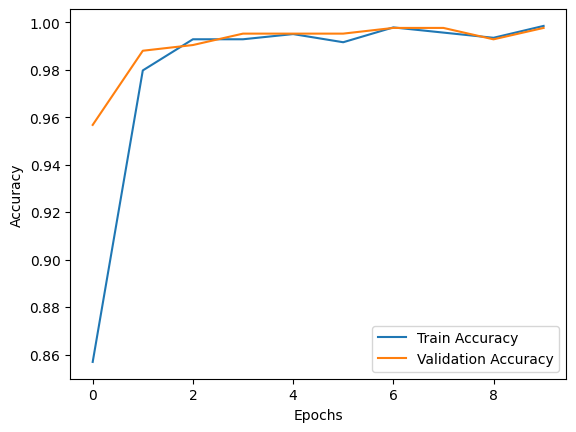

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [20]:
test_loss, test_accuracy = model.evaluate(test_data, verbose=1)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9974 - loss: 0.0073
Test Loss: 0.0073
Test Accuracy: 99.74%


1/1 [==============================] - 0s 113ms/step


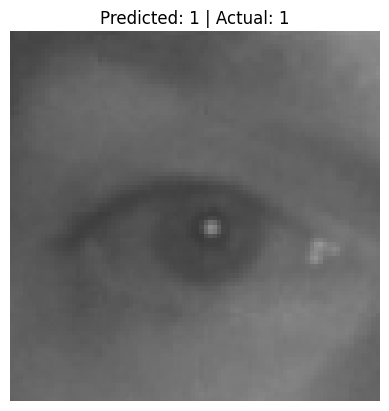

In [12]:
import matplotlib.pyplot as plt
import numpy as np

for images, labels in test_data.take(1):
    preds = model.predict(images)
    i = 0   # change index to test others
    
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f"Predicted: {np.argmax(preds[i])} | Actual: {labels[i]}")
    plt.axis("off")


1/1 [==============================] - 0s 60ms/step


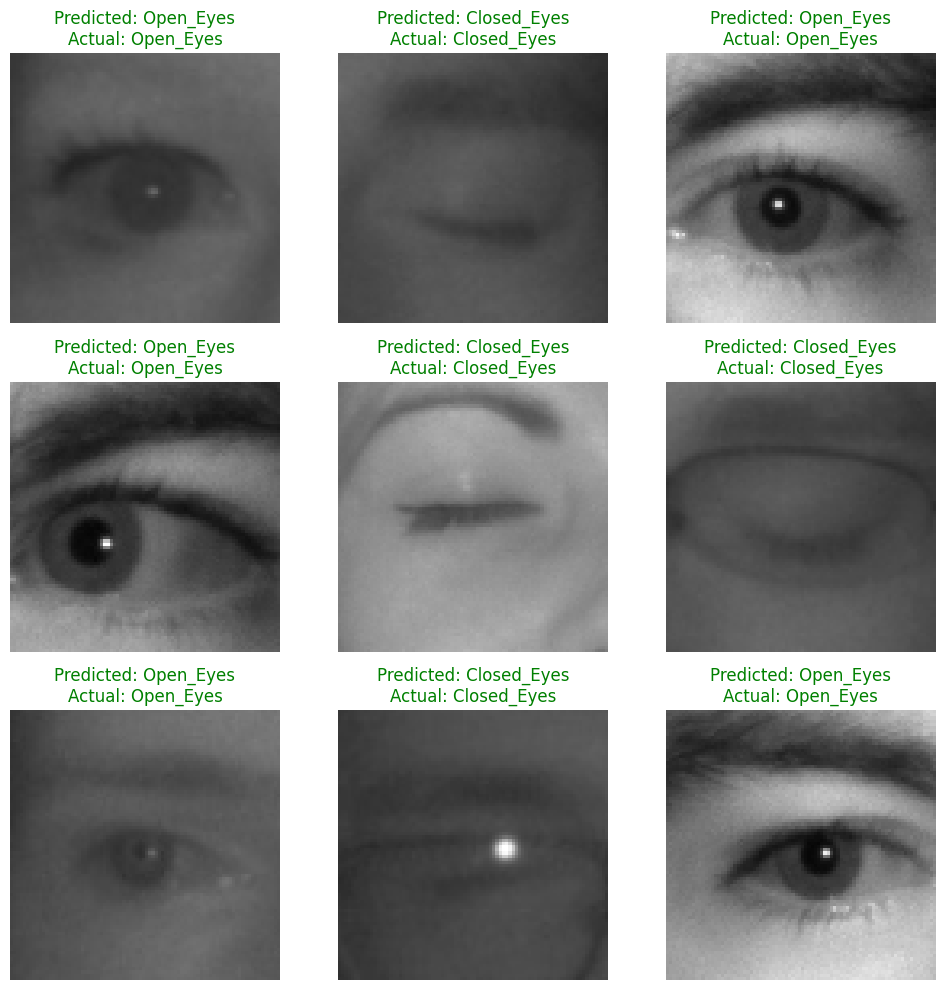

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Get class names
class_names = train_data.class_names

# Collect all test images & labels
all_images = []
all_labels = []

for images, labels in test_data:
    all_images.extend(images.numpy())
    all_labels.extend(labels.numpy())

all_images = np.array(all_images)
all_labels = np.array(all_labels)

# Randomly pick 9 samples
idx = random.sample(range(len(all_images)), 9)

sample_images = all_images[idx]
sample_labels = all_labels[idx]

# Predict
preds = model.predict(sample_images)
pred_classes = np.argmax(preds, axis=1)

# Plot 3x3 grid
plt.figure(figsize=(10,10))

for i in range(9):
    plt.subplot(3,3,i+1)
    
    plt.imshow(sample_images[i].astype("uint8"))
    
    true_label = class_names[sample_labels[i]]
    pred_label = class_names[pred_classes[i]]
    
    color = "green" if true_label == pred_label else "red"
    
    plt.title(f"Predicted: {pred_label}\nActual: {true_label}", color=color)
    
    plt.axis("off")

plt.tight_layout()
plt.show()


In [15]:
import tensorflow as tf
import numpy as np
import cv2
import os

# Load model
model = tf.keras.models.load_model("model/eye_detection_model2.keras")

class_names = ["Closed_Eyes", "Open_Eyes"]

img_path = "close.png"   # change path if needed


# Check file exists
if not os.path.exists(img_path):
    print("File not found:", img_path)
    print("Files here:", os.listdir())
    raise FileNotFoundError


# Read image
img = cv2.imread(img_path)

if img is None:
    raise ValueError("Could not read image")


# Convert BGR → RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Resize (same as training)
img = cv2.resize(img, (84,84))

# IMPORTANT: DO NOT normalize here
# img = img / 255.0   ❌ REMOVE THIS

# Convert to float32 (optional, safe)
img = img.astype("float32")

# Add batch dimension
img = np.expand_dims(img, axis=0)

# Predict
pred = model.predict(img, verbose=0)

pred_class = np.argmax(pred)
confidence = np.max(pred) * 100


print("Raw output:", pred)
print("Prediction:", class_names[pred_class])
print("Confidence:", round(confidence,2), "%")


Raw output: [[9.9976879e-01 2.3116963e-04]]
Prediction: Closed_Eyes
Confidence: 99.98 %


In [16]:
import cv2
import numpy as np
import tensorflow as tf

# -----------------------------
# Load model
# -----------------------------
model = tf.keras.models.load_model("model/eye_detection_model2.keras")

class_names = ["Closed_Eyes", "Open_Eyes"]

# -----------------------------
# Haar Cascades
# -----------------------------
face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

eye_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_eye.xml"
)

# -----------------------------
# Webcam
# -----------------------------
cap = cv2.VideoCapture(0)

print("Press 'q' to quit")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        face_color = frame[y:y+h, x:x+w]
        face_gray = gray[y:y+h, x:x+w]

        eyes = eye_cascade.detectMultiScale(face_gray)

        for (ex, ey, ew, eh) in eyes:

            eye = face_color[ey:ey+eh, ex:ex+ew]

            # Convert BGR to RGB (IMPORTANT)
            eye = cv2.cvtColor(eye, cv2.COLOR_BGR2RGB)

            eye = cv2.resize(eye, (84, 84))
            eye = np.reshape(eye, (1, 84, 84, 3))

            # Predict
            prediction = model.predict(eye, verbose=0)
            class_index = np.argmax(prediction)
            label = class_names[class_index]

            color = (0, 255, 0) if label == "Open_Eyes" else (0, 0, 255)

            cv2.rectangle(face_color, (ex, ey), (ex+ew, ey+eh), color, 2)
            cv2.putText(face_color, label,
                        (ex, ey - 10),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.6, color, 2)

    cv2.imshow("Eye Detection", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Press 'q' to quit


In [17]:
img = cv2.imread("close.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (84,84))
img = np.reshape(img, (1,84,84,3))

prediction = model.predict(img)
print(prediction)


1/1 [==============================] - 0s 15ms/step
[[9.9976879e-01 2.3116963e-04]]


In [18]:
img = cv2.imread("open.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (84,84))
img = np.reshape(img, (1,84,84,3))

prediction = model.predict(img)
print(prediction)


1/1 [==============================] - 0s 18ms/step
[[2.3574867e-04 9.9976426e-01]]


In [1]:
import tensorflow as tf
import mediapipe as mp
import google.protobuf

print("TF:", tf.__version__)
print("MP:", mp.__version__)
print("Protobuf:", google.protobuf.__version__)


TF: 2.13.0
MP: 0.10.14
Protobuf: 4.25.3


In [22]:
import cv2
import numpy as np
import tensorflow as tf
import mediapipe as mp

# -----------------------
# Load Model
# -----------------------
model = tf.keras.models.load_model("model/eye_detection_model2.keras")
class_names = ["Closed_Eyes", "Open_Eyes"]

# -----------------------
# MediaPipe Face Mesh
# -----------------------
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=False,
    max_num_faces=1,
    refine_landmarks=True
)

# -----------------------
# Webcam
# -----------------------
cap = cv2.VideoCapture(0)

print("Press 'q' to exit")

# while True:
#     ret, frame = cap.read()
#     if not ret:
#         break

#     frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#     results = face_mesh.process(frame_rgb)

#     if results.multi_face_landmarks:
#         for face_landmarks in results.multi_face_landmarks:

#             h, w, _ = frame.shape

#             # Left eye landmark indexes (MediaPipe standard)
#             LEFT_EYE = [33, 160, 158, 133, 153, 144]

#             x_coords = []
#             y_coords = []

#             for idx in LEFT_EYE:
#                 x_coords.append(int(face_landmarks.landmark[idx].x * w))
#                 y_coords.append(int(face_landmarks.landmark[idx].y * h))

#             # Get bounding box
#             x_min, x_max = min(x_coords), max(x_coords)
#             y_min, y_max = min(y_coords), max(y_coords)

#             # Add small margin
#             margin = 2
#             x_min = max(0, x_min - margin)
#             y_min = max(0, y_min - margin)
#             x_max = min(w, x_max + margin)
#             y_max = min(h, y_max + margin)

#             # Crop eye
#             eye = frame[y_min:y_max, x_min:x_max]

#             if eye.size == 0:
#                 continue

#             # Convert to grayscale first
#             eye_gray = cv2.cvtColor(eye, cv2.COLOR_BGR2GRAY)

#             # Resize
#             eye_gray = cv2.resize(eye_gray, (84, 84))

#             # Convert back to 3 channels (IMPORTANT)
#             eye_gray = cv2.cvtColor(eye_gray, cv2.COLOR_GRAY2RGB)

#             # Reshape
#             eye_input = np.reshape(eye_gray, (1, 84, 84, 3))


#             # Predict
#             prediction = model.predict(eye_input, verbose=0)
#             class_index = np.argmax(prediction)
#             label = class_names[class_index]

#             confidence = prediction[0][class_index]

#             color = (0, 255, 0) if label == "Open_Eyes" else (0, 0, 255)

#             cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), color, 2)
#             cv2.putText(frame,
#                         f"{label} ({confidence:.2f})",
#                         (x_min, y_min - 10),
#                         cv2.FONT_HERSHEY_SIMPLEX,
#                         0.6, color, 2)

#     cv2.imshow("MediaPipe Eye Detection", frame)
#     cv2.imshow("Eye Input", cv2.resize(eye_gray, (200,200)))

#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break
eye_gray_display = None  # to avoid error outside loop

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(frame_rgb)

    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:

            h, w, _ = frame.shape

            LEFT_EYE = [33, 160, 158, 133, 153, 144]

            x_coords = []
            y_coords = []

            for idx in LEFT_EYE:
                x_coords.append(int(face_landmarks.landmark[idx].x * w))
                y_coords.append(int(face_landmarks.landmark[idx].y * h))

            x_min, x_max = min(x_coords), max(x_coords)
            y_min, y_max = min(y_coords), max(y_coords)

            # Slightly better margin
            margin = 4
            x_min = max(0, x_min - margin)
            y_min = max(0, y_min - margin)
            x_max = min(w, x_max + margin)
            y_max = min(h, y_max + margin)

            eye = frame[y_min:y_max, x_min:x_max]

            if eye.size == 0:
                continue

            # Convert to grayscale
            eye_gray = cv2.cvtColor(eye, cv2.COLOR_BGR2GRAY)

            # Histogram equalization (IMPORTANT)
            eye_gray = cv2.equalizeHist(eye_gray)

            # Light blur to remove noise
            eye_gray = cv2.GaussianBlur(eye_gray, (3, 3), 0)

            # Resize
            eye_gray = cv2.resize(eye_gray, (84, 84))

            # Convert back to 3 channel
            eye_gray = cv2.cvtColor(eye_gray, cv2.COLOR_GRAY2RGB)

            eye_input = np.reshape(eye_gray, (1, 84, 84, 3))

            prediction = model.predict(eye_input, verbose=0)

            print("Prediction:", prediction)

            class_index = np.argmax(prediction)
            label = class_names[class_index]
            confidence = prediction[0][class_index]

            color = (0, 255, 0) if label == "Open_Eyes" else (0, 0, 255)

            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), color, 2)
            cv2.putText(frame,
                        f"{label} ({confidence:.2f})",
                        (x_min, y_min - 10),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.6, color, 2)

            eye_gray_display = eye_gray

    cv2.imshow("MediaPipe Eye Detection", frame)

    if eye_gray_display is not None:
        cv2.imshow("Eye Input", cv2.resize(eye_gray_display, (200, 200)))

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break


cap.release()
cv2.destroyAllWindows()


Press 'q' to exit
Prediction: [[1.1322696e-33 1.0000000e+00]]
Prediction: [[2.708508e-32 1.000000e+00]]
Prediction: [[1.6117214e-37 1.0000000e+00]]
Prediction: [[6.123534e-34 1.000000e+00]]
Prediction: [[2.2810388e-37 1.0000000e+00]]
Prediction: [[1.020536e-31 1.000000e+00]]
Prediction: [[9.992821e-33 1.000000e+00]]
Prediction: [[4.0199407e-35 1.0000000e+00]]
Prediction: [[1.1705965e-36 1.0000000e+00]]
Prediction: [[5.505914e-36 1.000000e+00]]
Prediction: [[5.505914e-36 1.000000e+00]]
Prediction: [[2.9732006e-35 1.0000000e+00]]
Prediction: [[4.643595e-36 1.000000e+00]]
Prediction: [[9.870548e-36 1.000000e+00]]
Prediction: [[1.5546266e-36 1.0000000e+00]]
Prediction: [[7.8788927e-35 1.0000000e+00]]
Prediction: [[3.6364392e-36 1.0000000e+00]]
Prediction: [[4.253843e-37 1.000000e+00]]
Prediction: [[5.0406466e-38 1.0000000e+00]]
Prediction: [[0. 1.]]
Prediction: [[0. 1.]]
Prediction: [[0. 1.]]
Prediction: [[0. 1.]]
Prediction: [[0. 1.]]
Prediction: [[0. 1.]]
Prediction: [[0. 1.]]
Prediction

In [6]:
import cv2
import numpy as np
import tensorflow as tf
import mediapipe as mp

# -----------------------
# Load Model
# -----------------------
model = tf.keras.models.load_model("model/eye_detection_model2.keras")
class_names = ["Closed_Eyes", "Open_Eyes"]

# -----------------------
# MediaPipe Face Mesh
# -----------------------
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=False,
    max_num_faces=1,
    refine_landmarks=True
)

# -----------------------
# Eye Landmarks
# -----------------------
LEFT_EYE = [33, 160, 158, 133, 153, 144]
RIGHT_EYE = [362, 385, 387, 263, 373, 380]

# -----------------------
# Drowsiness Counter
# -----------------------
closed_counter = 0
DROWSY_THRESHOLD = 20  # frames

# -----------------------
# Webcam
# -----------------------
cap = cv2.VideoCapture(0)
print("Press 'q' to exit")

def process_eye(eye_indices, frame, face_landmarks):
    h, w, _ = frame.shape

    x_coords = []
    y_coords = []

    for idx in eye_indices:
        x_coords.append(int(face_landmarks.landmark[idx].x * w))
        y_coords.append(int(face_landmarks.landmark[idx].y * h))

    x_min, x_max = min(x_coords), max(x_coords)
    y_min, y_max = min(y_coords), max(y_coords)

    margin = 4
    x_min = max(0, x_min - margin)
    y_min = max(0, y_min - margin)
    x_max = min(w, x_max + margin)
    y_max = min(h, y_max + margin)

    eye = frame[y_min:y_max, x_min:x_max]

    if eye.size == 0:
        return None, None, None

    # Preprocessing
    eye_gray = cv2.cvtColor(eye, cv2.COLOR_BGR2GRAY)
    eye_gray = cv2.equalizeHist(eye_gray)
    eye_gray = cv2.GaussianBlur(eye_gray, (3, 3), 0)
    eye_gray = cv2.resize(eye_gray, (84, 84))
    eye_gray = cv2.cvtColor(eye_gray, cv2.COLOR_GRAY2RGB)

    eye_input = np.reshape(eye_gray, (1, 84, 84, 3))

    prediction = model.predict(eye_input, verbose=0)
    class_index = np.argmax(prediction)
    confidence = prediction[0][class_index]

    return class_index, confidence, (x_min, y_min, x_max, y_max)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(frame_rgb)

    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:

            left_pred, left_conf, left_box = process_eye(LEFT_EYE, frame, face_landmarks)
            right_pred, right_conf, right_box = process_eye(RIGHT_EYE, frame, face_landmarks)

            if left_pred is not None and right_pred is not None:

                # Final decision logic
                if left_pred == 0 and right_pred == 0:
                    final_label = "Closed_Eyes"
                    final_conf = (left_conf + right_conf) / 2
                elif left_pred == 1 and right_pred == 1:
                    final_label = "Open_Eyes"
                    final_conf = (left_conf + right_conf) / 2
                else:
                    if left_conf > right_conf:
                        final_label = class_names[left_pred]
                        final_conf = left_conf
                    else:
                        final_label = class_names[right_pred]
                        final_conf = right_conf

                # Drowsiness counter
                if final_label == "Closed_Eyes":
                    closed_counter += 1
                else:
                    closed_counter = 0

                color = (0, 255, 0) if final_label == "Open_Eyes" else (0, 0, 255)

                # Draw eye boxes
                for box in [left_box, right_box]:
                    x_min, y_min, x_max, y_max = box
                    cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), color, 2)

                # Show label
                cv2.putText(frame,
                            f"{final_label} ({final_conf:.2f})",
                            (50, 50),
                            cv2.FONT_HERSHEY_SIMPLEX,
                            1, color, 2)

                # Drowsiness Alert
                if closed_counter > DROWSY_THRESHOLD:
                    cv2.putText(frame,
                                "DROWSINESS ALERT!",
                                (50, 100),
                                cv2.FONT_HERSHEY_SIMPLEX,
                                1.2, (0, 0, 255), 3)

    cv2.imshow("AI Drowsiness Detection", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Press 'q' to exit
